#Installazione pacchetti necessari

In [0]:
# Install required libs

### please update Albumentations to version>=0.3.0 for `Lambda` transform support
!pip install -U albumentations==0.3.0 --user 
!pip install -U --pre segmentation-models --user
#!pip install git+https://github.com/qubvel/segmentation_models --user

Requirement already up-to-date: albumentations==0.3.0 in /root/.local/lib/python3.6/site-packages (0.3.0)
Requirement already up-to-date: segmentation-models in /root/.local/lib/python3.6/site-packages (1.0.1)


# Connessione a directory Drive

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Loading Dataset immagini di input

In [0]:
import numpy as np
PATH_BASE = '/content/drive/My Drive/Appunti delle lezioni/2Anno2Semestre/Digital Image Processing/surface_normal_estimation_us/'

In [0]:
immagini_db = np.load(PATH_BASE + 'input_imgs_dataset.npy')

In [0]:
print(immagini_db.shape)
N = immagini_db.shape[0]

(1446, 195, 260, 3)


# Zero padding per estensione superficie immagini

In [0]:
immagini_db_zeropadding = np.load(PATH_BASE + "input_imgs_dataset_zeropadding.npy")

# Loading Clusterizzazione in 40 normali pixel per pixel

In [0]:
reshaped_labels = np.load(PATH_BASE + "normals_centroid_labels.npy")
codebook = np.load(PATH_BASE + "codebook_labels_3d_components.npy")

## Zero padding anche sulle label

In [0]:
reshaped_labels_zeropadding = np.load(PATH_BASE + "normals_centroid_labels_zeropadding.npy")

## Passaggio a 41 channel

Si passa da WxH a WxHxC dove C rappresenta i singoli cluster

In [0]:
reshaped_labels_processed_zeropadding = np.load(PATH_BASE + "normals_centroid_labels_41channels.npy")

# Modellizzazione

## Costruzione splitting

In [0]:
normali = np.load(PATH_BASE + '/normals_orig.npy')

In [0]:
seed(1221)
indexes = range(0,reshaped_labels_processed_zeropadding.shape[0])
permutated_indexes = np.random.permutation(indexes)
reshaped_labels_processed_zeropadding = reshaped_labels_processed_zeropadding[permutated_indexes, ...]
immagini_db_zeropadding = immagini_db_zeropadding[permutated_indexes, ...]

In [0]:
index_trainval = round(immagini_db_zeropadding.shape[0]*0.7)
x_trainval, y_trainval = immagini_db_zeropadding[:index_trainval, ...], reshaped_labels_processed_zeropadding[:index_trainval, ...]
x_test, y_test = immagini_db_zeropadding[index_trainval:, ...], reshaped_labels_processed_zeropadding[index_trainval:, ...]
normali_test = normali[index_trainval:, ]

In [0]:
index_train = round(x_trainval.shape[0]*0.8)
x_train, y_train = immagini_db_zeropadding[:index_train, ...], reshaped_labels_processed_zeropadding[:index_train, ...]
x_val, y_val = immagini_db_zeropadding[index_train:, ...], reshaped_labels_processed_zeropadding[index_train:, ...]

In [0]:
np.save(PATH_BASE + "x_padding_test.npy", x_test)
np.save(PATH_BASE + "y_padding_test.npy", y_test)
np.save(PATH_BASE + "normali_test.npy", normali_test)

## Costruzione modello

In [0]:
import cv2
import tensorflow as tf
import keras
#import tensorflow.keras
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [0]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x
    

# classes for data loading and preprocessing
class Dataset:
    """Normal surface dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        x (nparray): images
        y (nparray): label
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    def __init__(
            self, 
            x, 
            y, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.x = x
        self.y = y
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        if not isinstance(i, tuple):
          image = self.x[i]
          label = self.y[i]
        else:
          start, stop = i 
          image = self.x[start:stop,]
          label = self.y[start:stop,]
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, label=label)
            image, mask = sample['image'], sample['label']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, label=label)
            image, mask = sample['image'], sample['label']
            
        return image, label
        
    def __len__(self):
        return self.x.shape[0]
    
    
class Dataloder(keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()
# Rivedere senza fare copia degli oggetti
    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        #batch = [np.stack(samples, axis=0) for samples in zip(self.dataset[(start, stop)])]
        #batch = self.dataset[(start,stop)]
        return batch
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)   

In [0]:
import albumentations as A

def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

# define heavy augmentations
def get_training_augmentation():
    train_transform = [

        A.HorizontalFlip(p=0.5),

        A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        A.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        A.RandomCrop(height=320, width=320, always_apply=True),

        A.IAAAdditiveGaussianNoise(p=0.2),
        A.IAAPerspective(p=0.5),

        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightness(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.IAASharpen(p=1),
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.RandomContrast(p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
        A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        A.PadIfNeeded(384, 480)
    ]
    return A.Compose(test_transform)

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)

Costruzione modello

In [0]:
import segmentation_models as sm

# segmentation_models could also use `tf.keras` if you do not have Keras installed
# or you could switch to other framework using `sm.set_framework('tf.keras')`

Segmentation Models: using `keras` framework.


In [0]:
BACKBONE = 'efficientnetb3'
TRAIN_BATCH_SIZE = 8
VAL_BATCH_SIZE = 4
LR = 0.0001
EPOCHS = 40

preprocess_input = sm.get_preprocessing(BACKBONE)

In [0]:
# define network parameters
n_classes = 41
activation = 'softmax'

#create model
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation)

Calcolo dei pesi

In [0]:
class_weights = np.load(PATH_BASE + "label_weights_zeropadding.npy")

In [0]:
# define optomizer
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (car: 1.; pedestrian: 2.; background: 0.5;)
dice_loss = sm.losses.DiceLoss(class_weights=class_weights)
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

In [0]:
# Dataset for train images
train_dataset = Dataset(
    x_train, 
    y_train
    #augmentation=get_training_augmentation(),
    #preprocessing=get_preprocessing(preprocess_input),
)

# Dataset for validation images
valid_dataset = Dataset(
    x_val, 
    y_val
    #augmentation=get_validation_augmentation(),
    #preprocessing=get_preprocessing(preprocess_input),
)

train_dataloader = Dataloder(train_dataset, TRAIN_BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, VAL_BATCH_SIZE, shuffle=False)

# check shapes for errors
assert train_dataloader[0][0].shape == (TRAIN_BATCH_SIZE, 320, 320, 3)
assert train_dataloader[0][1].shape == (TRAIN_BATCH_SIZE, 320, 320, 41)

# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('./best_model.h5', save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
]

In [0]:
# train model
history = model.fit_generator(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)

Epoch 1/40
101/101 [==============================] - 203s 2s/step - loss: 0.9639 - iou_score: 0.0040 - f1-score: 0.0073 - val_loss: 0.9714 - val_iou_score: 0.0060 - val_f1-score: 0.0107
Epoch 2/40
101/101 [==============================] - 197s 2s/step - loss: 0.9251 - iou_score: 0.0106 - f1-score: 0.0186 - val_loss: 0.9524 - val_iou_score: 0.0100 - val_f1-score: 0.0175
Epoch 3/40
101/101 [==============================] - 197s 2s/step - loss: 0.8693 - iou_score: 0.0170 - f1-score: 0.0293 - val_loss: 0.9168 - val_iou_score: 0.0122 - val_f1-score: 0.0215
Epoch 4/40
101/101 [==============================] - 197s 2s/step - loss: 0.8034 - iou_score: 0.0242 - f1-score: 0.0420 - val_loss: 0.8666 - val_iou_score: 0.0153 - val_f1-score: 0.0272
Epoch 5/40
101/101 [==============================] - 197s 2s/step - loss: 0.7389 - iou_score: 0.0329 - f1-score: 0.0566 - val_loss: 0.8594 - val_iou_score: 0.0197 - val_f1-score: 0.0349
Epoch 6/40
101/101 [==============================] - 197s 2s/ste

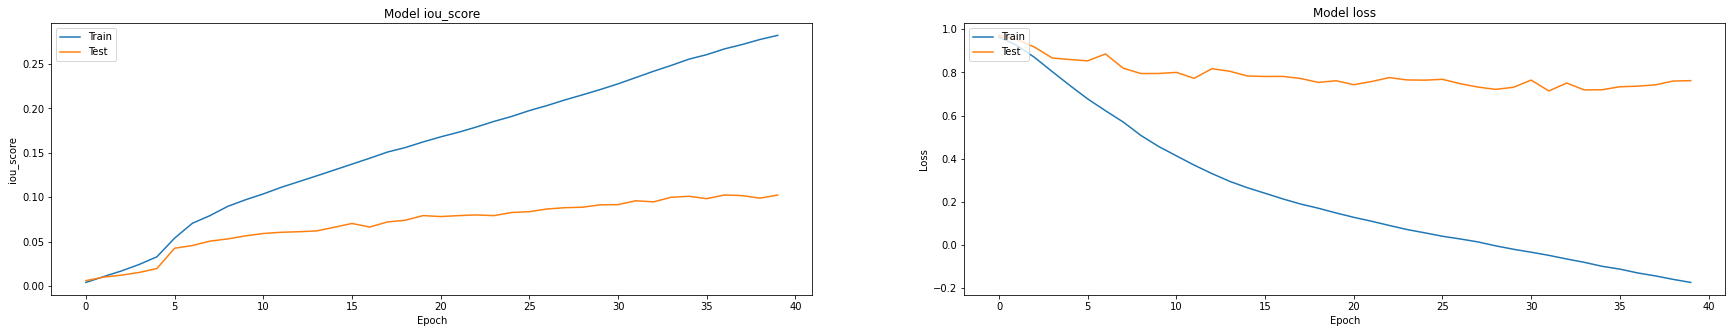

In [0]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Calcolo output predizionale della rete

In [0]:
from keras.models import load_model
model.load_weights("best_model.h5")

In [0]:
y_test_p = model.predict(x_test, batch_size=1)

In [0]:
np.save(PATH_BASE + "prediction_test_padded.npy", y_test_p)

# Rifiltraggio output togliendo cluster numero 40

Il cluster numero 40 aggiunto per gestire il padding, deve essere rimosso. In particolare, l'immagine viene riportata alle dimensioni originali sulle quali è stato effettuato il clustering. Se un punto interno all'immagine originale presenta come classe individuata il cluster 40, si opera con nearest neighbour per riportarsi nello spazio del cluster originale.

In [0]:
y_test_p.shape

(434, 320, 320, 41)

In [0]:
sample_p = y_test_p[0]

In [0]:
sample_p_depadded = np.zeros((195, 260, 40))
for h in range(0,sample_p_depadded.shape[0]):
  for w in range(0,sample_p_depadded.shape[1]):
    for c in range(0,sample_p_depadded.shape[2]):
      sample_p_depadded[h][w][c] = sample_p[h][w][c]

# Ricalcolo superfici normali da classificazione

In [0]:
import scipy as sp
import matplotlib.pyplot as plt
from scipy import spatial

# Triangolazione di delaunay a partire dai 40 centroidi di riferimento.
def get_delaunay_triangulation(codebook):
  tri = sp.spatial.Delaunay(codebook[:,0:2]) # perform triangulation over x and y coordinates (z is function of (x,y))
  #print(tri.simplices)
  plt.figure()
  plt.axes().set_aspect('equal')
  #plt.triplot(codebook[:,0], codebook[:,1], tri.simplices.copy())
  plt.plot(codebook[:,0], codebook[:,1], 'o')
  plt.show()
  return tri.simplices

In [0]:
# Metodo che permette di ottenere la normale 3d per ogni pixel a partire dalla predizione della rete.
# INPUT
# netPrediction: shape = (H, W, 40). Predizione della rete di un'immagine. 
#                Per ogni pixel la rete fornisce un vettore di 40 probabilità (1 per ogni centroide).
# codebook:      shape = (40,3). Lista delle 40 normali di riferimento (centroidi). codebook.shape = (40,3)
# triangoli:     shape = (N, 3). Triangolazione di delaunay; ogni elemento di questo vettore è una tripla di indici di centroidi, da utilizzare
#                nel codebook ottenuto con la clusterizzazione. (es. N = 67)
# OUTPUT
# norm:          shape = (H, W, 3). Normali 3d pixel per pixel dell'immagine.

def decode(netPrediction, codebook, triangoli):
  h, w = netPrediction.shape[0:2]
  
  # for each triangle, get total prob
  tri_prob = np.dstack([np.sum(netPrediction[:,:,t], axis = -1) for t in triangoli]) 

  # get best tri
  best_tri = np.argmax(tri_prob, axis = -1)
  
  # get coefficients to most probable tri
  alphas = np.reshape([netPrediction[row, col, triangoli[best_tri[row, col]]] for row in range(h) for col in range(w)], (h, w, 3))

  # sum -> 1
  alphas = np.divide(alphas, np.reshape(np.tile(np.sum(alphas, axis = -1), (1,3)), (h, w, 3)))
  alphas = np.reshape(np.tile(alphas, (1,1,3)), (h, w,3,3))  
  alphas = np.swapaxes(alphas, 2,3)

  norm = np.multiply(alphas, codebook[triangoli[best_tri]])
  norm = np.sum(norm, axis = -2)
  
  return norm

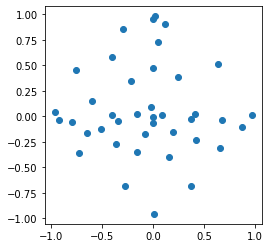

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(195, 260, 3)


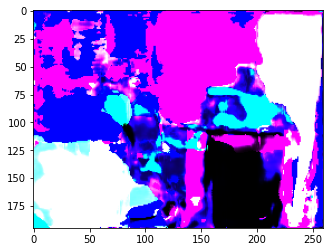

In [0]:
# chiamo la funzione di decodifica e ottengo la mappa delle normali 3d
netPrediction_3d = decode(sample_p_depadded, codebook, get_delaunay_triangulation(codebook))
print(netPrediction_3d.shape)

%matplotlib inline
import matplotlib.pyplot as plt
#plt.figure('es. predizione decodificata')
plt.imshow(255/2 * netPrediction_3d)

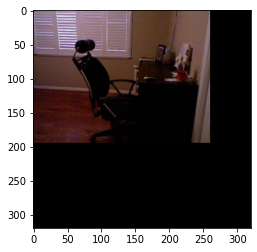

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
#plt.figure('es. predizione decodificata')
plt.imshow(x_test[0])

# Valutazione

In [0]:
# pixel wise evaluation
# INPUT
# prediction:   shape = (1,3) normale predetta dalla rete (ottenuta come codifica dalle label)
# ground_truth: shape = (1,3) normale effettiva
# OUTPUT
# l'errore in radianti tra la normale passata e quella effettiva
def eval_cosine(prediction, ground_truth):
  if np.sum(ground_truth) == 0 or np.sum(prediction) == 0:
    return 0
  cosine = np.dot(prediction, ground_truth) / (np.linalg.norm(prediction) * np.linalg.norm(ground_truth))
  if (cosine <= 1 and cosine >= -1):
    return np.arccos(cosine) 
  return np.deg2rad(180) if cosine < -1 else 0

# questa funzione va chiamata su tutti i pixel di tutte le immagini del test-set o validation set.

In [0]:
# TODO: effettuare la predizione su tutto il test-set (es: 30% del dataset "normals_orig.npy") con la rete. 
# Dopodichè decodificare le predizioni per ogni immagine (label -> normali 3d) e possibilmente salvare in un file (es: "prediction_test_decoded.npy").

# es. di test-set
idx_test = np.random.randint(0, N, int(0.3 * N))
normali_test = normali[idx_test]

# NOTA: nel calcolo della metrica non vanno considerati i pixel rumorosi, che sono identificati dalla tripla [0,0,0].
tot_noised_pixel = np.where(np.sum(normali_test, axis = -1) == 0)[0].shape[0]
tot_pixel = normali_test.shape[0] * normali_test.shape[1] * normali_test.shape[2]
valid_pixel = tot_pixel - tot_noised_pixel

print('Noised pixel / Tot pixel (%):', tot_noised_pixel / tot_pixel * 100)
print('Mean: ', np.rad2deg(np.sum(theta) / valid_pixel))

# es: carico da file
# theta = np.load("prediction_test_decoded.npy")

# valuto la percentuale di errori angolari inferiori rispetto ad una delle seguenti soglie
soglie_errori = [11.25, 22.5, 30]
for th in soglie_errori:
  under_th = (np.where(theta < np.deg2rad(th))[0].shape[0] - noised_pixel) / valid_pixel * 100
  print('Threshold', str(th),  under_th)